## Testing the model

In [1]:
import os
import torch
import random
import numpy as np
import pandas as pd
import json
import rasterio as rio
from matplotlib import pyplot as plt
from rasterio.plot import show
import re
import cv2
import csv
from PIL import Image, ImageDraw, ImageFont
from shapely.geometry import Polygon
from imantics import Polygons, Mask
from scipy.ndimage.morphology import distance_transform_edt
import glob

In [2]:
cd ../..

/Users/shimash


In [3]:
"""SpaceNet6 Dataset."""

class SpaceNetDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        csv_dir,
        image_dir,
        sar_dir,
#         test_dir,
        transform=None,
    ):
        """
        Args:
            image_dir (string): Path to RGB images directory.
            sar_dir (string): ...
            mask_dir (string): ... 
            tile_number (string): ...
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.csv_dir = csv_dir
        self.data = pd.read_csv(csv_dir)
        self.image_dir = image_dir
        self.sar_dir = sar_dir
        self.mask_list = self.create_poly_list()
        self.transform = transform
        self.tile_id_list = self.tile_id_list()
#         self.test_dir = test_dir
#         self.test_id_list = self.test_id_list()
        
    def __len__(self):
        return len(self.tile_id_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        image = self.get_rgb(idx)
        mask = self.get_mask(idx)
        sar = self.get_sar(idx)
        edge = self.get_edge(idx, mask)
        
        if self.transform:
            image, mask, _ = self.transform(image, mask)

        return sar.float(), mask.float(), image.float(), edge.float() 
    
    def get_sar(self, idx):
        create_SAR_path = self.sar_dir +"SN6_Train_AOI_11_Rotterdam_SAR-Intensity_" + self.tile_id_list[idx][0] + ".tif"
        with rio.open(create_SAR_path) as lidar_dem:
            img = np.zeros((900,900,4))
            img[:,:,0] = lidar_dem.read(1)
            img[:,:,1] = lidar_dem.read(2)
            img[:,:,2] = lidar_dem.read(3)
            img[:,:,3] = lidar_dem.read(4)
        return torch.from_numpy(img*255/np.max(img))
    
    def get_rgb(self, idx):
        create_RGB_path = self.image_dir +"SN6_Train_AOI_11_Rotterdam_PS-RGB_" + self.tile_id_list[idx][0] + ".tif"
        with rio.open(create_RGB_path) as lidar_dem:
            img = np.zeros((900,900,3))
            img[:,:,0] = lidar_dem.read(1)
            img[:,:,1] = lidar_dem.read(2)
            img[:,:,2] = lidar_dem.read(3)
        return torch.from_numpy(img)

    def get_mask(self, idx):
        return self.generate_mask(self.mask_list[idx][1], self.mask_list[idx][2])
         
    def generate_mask(self, start, end):
        mask_img = Image.new('1', (900, 900), 0)
        poly = ImageDraw.Draw(mask_img)
        for i in range(start,end+1):
            row = self.data.loc[i,'PolygonWKT_Pix']
            expression = re.findall("[-+]?[.]?[\d]+(?:,\d\d\d)*[\.]?\d*(?:[eE][-+]?\d+)?", row)
            tup = (float(expression[0]), float(expression[1]))
            for i in range(2,len(expression),2):
                temp = (float(expression[i]),float(expression[i+1]))
                tup = tup + temp
            poly.polygon(tup, outline = 1, fill = 1)
        mask = np.array(mask_img)
        mask = torch.from_numpy(mask).float()
        return mask 
    
    def onehot_to_binary_edges(self, mask, radius):
        mask = mask.numpy()
        if radius < 0:
            return mask
        mask = mask.astype(np.uint8)
        # We need to pad the borders for boundary conditions
        mask_pad = np.pad(mask, ((1, 1), (1, 1)), mode='constant', constant_values=0)
        edgemap = np.zeros(mask.shape)
        dist = distance_transform_edt(mask_pad)
        #print(dist)
        dist = dist[1:-1, 1:-1]
        dist[dist > radius] = 0
        edgemap += dist
#         edgemap = np.expand_dims(edgemap, axis=0)    
#         edgemap = (edgemap > 0).astype(np.uint8)
        return edgemap
    
    def get_edge(self, idx, mask):
        _edgemap = mask
        _edgemap = self.onehot_to_binary_edges(_edgemap, 1)
        edgemap = torch.from_numpy(_edgemap).float()
        return edgemap
    
    def create_poly_list(self):
        pointer = 0
        poly_index_list = []
        while pointer < len(self.data):
            start = pointer
            end = pointer
            tile_number_st = self.data['ImageId'][pointer].rfind('_')
            tile_number = self.data['ImageId'][pointer][tile_number_st+1:]
            while (pointer+2) < len(self.data) and (self.data['TileBuildingId'][pointer] < self.data['TileBuildingId'][pointer+1]):
                end +=1
                pointer +=1
            poly_index_list.append([tile_number, start, end, self.data['ImageId'][pointer]])
            pointer +=1
        return poly_index_list
        
    def random_rotation(self, image, mask):
        orient = np.random.randint(0, 4)
        image = np.rot90(image, orient)
        mask = np.rot90(mask, orient)
        sar = np.rot90(sar, orient)
        return image, mask, sar, orient

    def tile_id_list(self):
        tile_list = []
        csv_list = self.create_poly_list()
        for tile in range(len(csv_list)):
            tile_list.append([csv_list[tile][3], csv_list[tile][0]])
        return tile_list
    
    def create_output_csv(self):
        with open('solution.csv', 'w') as csv_file:
            fieldnames = ['ImageId','PolygonWKT_Pix','Confidence']
            writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
            writer.writeheader()
    
    def csv_add_newline(self, image_id, polygons, score):
        with open('solution.csv', 'a', newline='') as csv_file:
            fieldnames = ['ImageId','PolygonWKT_Pix','Confidence']
            writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
            writer.writerow({'ImageId': image_id, 'PolygonWKT_Pix': polygons, 'Confidence': score})
    
    def create_polygon(self, idx, mask):
        mask = mask.numpy()
        binary_mask = mask.astype(np.uint8)
        contours, hierarchy = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for i in range (len(contours)):
            points = []
            contour = np.squeeze(contours[i])
            for j in range(len(contour)):
                points.append((contour[j][0], contour[j][1]))
            if contour.shape[0] >= 3:
                polygon = Polygon(points)   
            #add a newline to csv!   
            image_id = self.mask_list[idx][3]
            self.csv_add_newline(image_id, polygon.wkt, 1.0)
            #print(polygon.wkt)

In [4]:
vec_dir = "data/train/AOI_11_Rotterdam/geojson_buildings/"
img_dir = "data/train/AOI_11_Rotterdam/PS-RGB/"
sar_dir = "data/train/AOI_11_Rotterdam/SAR-Intensity/"
out_dir = "data/train/AOI_11_Rotterdam/gt_masks/"
csv_dir = "data/train/AOI_11_Rotterdam/SummaryData/SN6_Train_AOI_11_Rotterdam_Buildings.csv"

test_space = SpaceNetDataset(csv_dir=csv_dir, image_dir=img_dir, sar_dir=sar_dir)

In [5]:
sar, mask, rgb, edge =  test_space[0]
sar_1, mask_1, rgb_1, edge_1 =  test_space[1]


In [6]:
# rgb_test = rgb.unsqueeze(0).view((1,3,900,900))
# rgb_test_1 = rgb_1.unsqueeze(0).view((1,3,900,900))
rgb_test = sar
rgb_test_1 = sar_1
rgb_test = rgb_test.cpu().numpy()
rgb_test_1 = rgb_test_1.cpu().numpy()

rgb_resized = cv2.resize(rgb_test, (224, 224)) 
rgb_1_resized = cv2.resize(rgb_test_1, (224, 224)) 

rgb_resized = torch.from_numpy(rgb_resized).float()
rgb_1_resized = torch.from_numpy(rgb_1_resized).float()

rgb_out = rgb_resized.unsqueeze(0).view((1,4,224,224))
rgb_out_1 = rgb_1_resized.unsqueeze(0).view((1,4,224,224))

print(rgb_resized.shape)
test = torch.cat((rgb_out, rgb_out_1),0)

torch.Size([224, 224, 4])


In [27]:
# test.size()

In [29]:
import numpy as np
from multiprocessing import Pool
from tqdm import tqdm

""" Utilities for computing, reading and saving benchmark evaluation."""

def eval_mask_boundary(seg_mask,gt_mask,num_classes=2,num_proc=10,bound_th=0.008):
    """
    Compute F score for a segmentation mask

    Arguments:
        seg_mask (ndarray): segmentation mask prediction
        gt_mask (ndarray): segmentation mask ground truth
        num_classes (int): number of classes

    Returns:
        F (float): mean F score across all classes
        Fpc (listof float): F score per class
    """
    p = Pool(processes=num_proc)
    batch_size = seg_mask.shape[0]
    
    Fpc = np.zeros(num_classes)
    Fc = np.zeros(num_classes)
    for class_id in tqdm(range(num_classes)):
        args = [((seg_mask[i] == class_id).astype(np.uint8), 
                 (gt_mask[i] == class_id).astype(np.uint8),
                 gt_mask[i] == 255,
                 bound_th) 
                 for i in range(batch_size)]
        temp = p.map(db_eval_boundary_wrapper, args)
        temp = np.array(temp)
        Fs = temp[:,0]
        _valid = ~np.isnan(Fs)
        Fc[class_id] = np.sum(_valid)
        Fs[np.isnan(Fs)] = 0
        Fpc[class_id] = sum(Fs)
    return Fpc, Fc



  0%|          | 0/2 [00:00<?, ?it/s]


AttributeError: 'Tensor' object has no attribute 'astype'

In [34]:

#def db_eval_boundary_wrapper_wrapper(args):
#    seg_mask, gt_mask, class_id, batch_size, Fpc = args
#    print("class_id:" + str(class_id))
#    p = Pool(processes=10)
#    args = [((seg_mask[i] == class_id).astype(np.uint8), 
#             (gt_mask[i] == class_id).astype(np.uint8)) 
#             for i in range(batch_size)]
#    Fs = p.map(db_eval_boundary_wrapper, args)
#    Fpc[class_id] = sum(Fs)
#    return

# def db_eval_boundary_wrapper(args):
#     foreground_mask, gt_mask, ignore, bound_th = args
#     return db_eval_boundary(foreground_mask, gt_mask,ignore, bound_th)

def db_eval_boundary(foreground_mask,gt_mask, ignore_mask,bound_th=0.008):
	"""
	Compute mean,recall and decay from per-frame evaluation.
	Calculates precision/recall for boundaries between foreground_mask and
	gt_mask using morphological operators to speed it up.

	Arguments:
		foreground_mask (ndarray): binary segmentation image.
		gt_mask         (ndarray): binary annotated image.

	Returns:
		F (float): boundaries F-measure
		P (float): boundaries precision
		R (float): boundaries recall
	"""
	assert np.atleast_3d(foreground_mask).shape[2] == 1

	bound_pix = bound_th if bound_th >= 1 else \
			np.ceil(bound_th*np.linalg.norm(foreground_mask.shape))

	#print(bound_pix)
	#print(gt.shape)
	#print(np.unique(gt))
	foreground_mask[ignore_mask] = 0
	gt_mask[ignore_mask] = 0

	# Get the pixel boundaries of both masks
	fg_boundary = seg2bmap(foreground_mask);
	gt_boundary = seg2bmap(gt_mask);

	from skimage.morphology import binary_dilation,disk

	fg_dil = binary_dilation(fg_boundary,disk(bound_pix))
	gt_dil = binary_dilation(gt_boundary,disk(bound_pix))

	# Get the intersection
	gt_match = gt_boundary * fg_dil
	fg_match = fg_boundary * gt_dil

	# Area of the intersection
	n_fg     = np.sum(fg_boundary)
	n_gt     = np.sum(gt_boundary)

	#% Compute precision and recall
	if n_fg == 0 and  n_gt > 0:
		precision = 1
		recall = 0
	elif n_fg > 0 and n_gt == 0:
		precision = 0
		recall = 1
	elif n_fg == 0  and n_gt == 0:
		precision = 1
		recall = 1
	else:
		precision = np.sum(fg_match)/float(n_fg)
		recall    = np.sum(gt_match)/float(n_gt)

	# Compute F measure
	if precision + recall == 0:
		F = 0
	else:
		F = 2*precision*recall/(precision+recall);

	return F, precision

#checked
def seg2bmap(seg,width=None,height=None):
	"""
	From a segmentation, compute a binary boundary map with 1 pixel wide
	boundaries.  The boundary pixels are offset by 1/2 pixel towards the
	origin from the actual segment boundary.

	Arguments:
		seg     : Segments labeled from 1..k.
		width	  :	Width of desired bmap  <= seg.shape[1]
		height  :	Height of desired bmap <= seg.shape[0]

	Returns:
		bmap (ndarray):	Binary boundary map.

	 David Martin <dmartin@eecs.berkeley.edu>
	 January 2003
 """

	seg = seg.astype(np.bool)
	seg[seg>0] = 1

	assert np.atleast_3d(seg).shape[2] == 1

	width  = seg.shape[1] if width  is None else width
	height = seg.shape[0] if height is None else height

	h,w = seg.shape[:2]

	ar1 = float(width) / float(height)
	ar2 = float(w) / float(h)

	assert not (width>w | height>h | abs(ar1-ar2)>0.01),\
			'Can''t convert %dx%d seg to %dx%d bmap.'%(w,h,width,height)

	e  = np.zeros_like(seg)
	s  = np.zeros_like(seg)
	se = np.zeros_like(seg)

	e[:,:-1]    = seg[:,1:]
	s[:-1,:]    = seg[1:,:]
	se[:-1,:-1] = seg[1:,1:]

	b        = seg^e | seg^s | seg^se
	b[-1,:]  = seg[-1,:]^e[-1,:]
	b[:,-1]  = seg[:,-1]^s[:,-1]
	b[-1,-1] = 0

	if w == width and h == height:
		bmap = b
	else:
		bmap = np.zeros((height,width))
		for x in range(w):
			for y in range(h):
				if b[y,x]:
					j = 1+floor((y-1)+height / h)
					i = 1+floor((x-1)+width  / h)
					bmap[j,i] = 1;

	return bmap


In [8]:
class AttrDict(dict):

    IMMUTABLE = '__immutable__'

    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__[AttrDict.IMMUTABLE] = False

    def __getattr__(self, name):
        if name in self.__dict__:
            return self.__dict__[name]
        elif name in self:
            return self[name]
        else:
            raise AttributeError(name)

    def __setattr__(self, name, value):
        if not self.__dict__[AttrDict.IMMUTABLE]:
            if name in self.__dict__:
                self.__dict__[name] = value
            else:
                self[name] = value
        else:
            raise AttributeError(
                'Attempted to set "{}" to "{}", but AttrDict is immutable'.
                format(name, value)
            )

    def immutable(self, is_immutable):
        """Set immutability to is_immutable and recursively apply the setting
        to all nested AttrDicts.
        """
        self.__dict__[AttrDict.IMMUTABLE] = is_immutable
        # Recursively set immutable state
        for v in self.__dict__.values():
            if isinstance(v, AttrDict):
                v.immutable(is_immutable)
        for v in self.values():
            if isinstance(v, AttrDict):
                v.immutable(is_immutable)

    def is_immutable(self):
        return self.__dict__[AttrDict.IMMUTABLE]

In [9]:
import argparse

# Argument Parser
parser = argparse.ArgumentParser(description='GSCNN')
parser.add_argument('--lr', type=float, default=0.01)
parser.add_argument('--arch', type=str, default='network.gscnn.GSCNN')
parser.add_argument('--dataset', type=str, default='cityscapes')
parser.add_argument('--cv', type=int, default=0,
                    help='cross validation split')
parser.add_argument('--joint_edgeseg_loss', action='store_true', default=True,
                    help='joint loss')
parser.add_argument('--img_wt_loss', action='store_true', default=False,
                    help='per-image class-weighted loss')
parser.add_argument('--batch_weighting', action='store_true', default=False,
                    help='Batch weighting for class')
parser.add_argument('--eval_thresholds', type=str, default='0.0005,0.001875,0.00375,0.005',
                    help='Thresholds for boundary evaluation')
parser.add_argument('--rescale', type=float, default=1.0,
                    help='Rescaled LR Rate')
parser.add_argument('--repoly', type=float, default=1.5,
                    help='Rescaled Poly')

parser.add_argument('--edge_weight', type=float, default=1.0,
                    help='Edge loss weight for joint loss')
parser.add_argument('--seg_weight', type=float, default=1.0,
                    help='Segmentation loss weight for joint loss')
parser.add_argument('--att_weight', type=float, default=1.0,
                    help='Attention loss weight for joint loss')
parser.add_argument('--dual_weight', type=float, default=1.0,
                    help='Dual loss weight for joint loss')

parser.add_argument('--evaluate', action='store_true', default=False)

parser.add_argument("--local_rank", default=0, type=int)

parser.add_argument('--sgd', action='store_true', default=True)
parser.add_argument('--sgd_finetuned',action='store_true',default=False)
parser.add_argument('--adam', action='store_true', default=False)
parser.add_argument('--amsgrad', action='store_true', default=False)

parser.add_argument('--trunk', type=str, default='resnet101',
                    help='trunk model, can be: resnet101 (default), resnet50')
parser.add_argument('--max_epoch', type=int, default=175)
parser.add_argument('--start_epoch', type=int, default=0)
parser.add_argument('--color_aug', type=float,
                    default=0.25, help='level of color augmentation')
parser.add_argument('--rotate', type=float,
                    default=0, help='rotation')
parser.add_argument('--gblur', action='store_true', default=True)
parser.add_argument('--bblur', action='store_true', default=False) 
parser.add_argument('--lr_schedule', type=str, default='poly',
                    help='name of lr schedule: poly')
parser.add_argument('--poly_exp', type=float, default=1.0,
                    help='polynomial LR exponent')
parser.add_argument('--bs_mult', type=int, default=1)
parser.add_argument('--bs_mult_val', type=int, default=2)
parser.add_argument('--crop_size', type=int, default=720,
                    help='training crop size')
parser.add_argument('--pre_size', type=int, default=None,
                    help='resize image shorter edge to this before augmentation')
parser.add_argument('--scale_min', type=float, default=0.5,
                    help='dynamically scale training images down to this size')
parser.add_argument('--scale_max', type=float, default=2.0,
                    help='dynamically scale training images up to this size')
parser.add_argument('--weight_decay', type=float, default=1e-4)
parser.add_argument('--momentum', type=float, default=0.9)
parser.add_argument('--snapshot', type=str, default=None)
parser.add_argument('--restore_optimizer', action='store_true', default=False)
parser.add_argument('--exp', type=str, default='default',
                    help='experiment directory name')
parser.add_argument('--tb_tag', type=str, default='',
                    help='add tag to tb dir')
parser.add_argument('--ckpt', type=str, default='logs/ckpt')
parser.add_argument('--tb_path', type=str, default='logs/tb')
parser.add_argument('--syncbn', action='store_true', default=False,
                    help='Synchronized BN')
parser.add_argument('--dump_augmentation_images', action='store_true', default=False,
                    help='Synchronized BN')
parser.add_argument('--test_mode', action='store_true', default=False,
                    help='minimum testing (1 epoch run ) to verify nothing failed')
parser.add_argument('-wb', '--wt_bound', type=float, default=1.0)
parser.add_argument('--maxSkip', type=int, default=0)
# args = parser.parse_args()
# args.best_record = {'epoch': -1, 'iter': 0, 'val_loss': 1e10, 'acc': 0,
#                         'acc_cls': 0, 'mean_iu': 0, 'fwavacc': 0}


_StoreAction(option_strings=['--maxSkip'], dest='maxSkip', nargs=None, const=None, default=0, type=<class 'int'>, choices=None, help=None, metavar=None)

In [24]:
"""
Copyright (C) 2019 NVIDIA Corporation.  All rights reserved.
Licensed under the CC BY-NC-SA 4.0 license (https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode).

# Code adapted from:
# https://github.com/ericjang/gumbel-softmax/blob/3c8584924603869e90ca74ac20a6a03d99a91ef9/Categorical%20VAE.ipynb
#
# MIT License
#
# Copyright (c) 2016 Eric Jang
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.
"""

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

def compute_grad_mag(E, cuda=False):
    E_ = convTri(E, 4, cuda)
    Ox, Oy = numerical_gradients_2d(E_, cuda)
    mag = torch.sqrt(torch.mul(Ox,Ox) + torch.mul(Oy,Oy) + 1e-6)
    mag = mag / mag.max();

    return mag


def perturbate_input_(input, n_elements=200):
    N, C, H, W = input.shape
    assert N == 1
    c_ = np.random.random_integers(0, C - 1, n_elements)
    h_ = np.random.random_integers(0, H - 1, n_elements)
    w_ = np.random.random_integers(0, W - 1, n_elements)
    for c_idx in c_:
        for h_idx in h_:
            for w_idx in w_:
                input[0, c_idx, h_idx, w_idx] = 1
    return input

def _sample_gumbel(shape, eps=1e-10):
    """
    Sample from Gumbel(0, 1)

    based on
    https://github.com/ericjang/gumbel-softmax/blob/3c8584924603869e90ca74ac20a6a03d99a91ef9/Categorical%20VAE.ipynb ,
    (MIT license)
    """
    U = torch.rand(shape).cuda()
    return - torch.log(eps - torch.log(U + eps))


def _gumbel_softmax_sample(logits, tau=1, eps=1e-10):
    """
    Draw a sample from the Gumbel-Softmax distribution

    based on
    https://github.com/ericjang/gumbel-softmax/blob/3c8584924603869e90ca74ac20a6a03d99a91ef9/Categorical%20VAE.ipynb
    (MIT license)
    """
    assert logits.dim() == 3
    gumbel_noise = _sample_gumbel(logits.size(), eps=eps)
    y = logits + gumbel_noise
    return F.softmax(y / tau, 1)


def _one_hot_embedding(labels, num_classes):
    """Embedding labels to one-hot form.

    Args:
      labels: (LongTensor) class labels, sized [N,].
      num_classes: (int) number of classes.

    Returns:
      (tensor) encoded labels, sized [N, #classes].
    """

    y = torch.eye(num_classes).cuda()
    return y[labels].permute(0,3,1,2)

class DualTaskLoss(nn.Module):
    def __init__(self, cuda=False):
        super(DualTaskLoss, self).__init__()
        self._cuda = cuda
        return

    def forward(self, input_logits, gts, ignore_pixel=255):
        """
        :param input_logits: NxCxHxW
        :param gt_semantic_masks: NxCxHxW
        :return: final loss
        """
        N, C, H, W = input_logits.shape
        th = 1e-8  # 1e-10
        eps = 1e-10
        ignore_mask = (gts == ignore_pixel).detach()
        input_logits = torch.where(ignore_mask.view(N, 1, H, W).expand(N, 19, H, W),
                                   torch.zeros(N,C,H,W).cuda(),
                                   input_logits)
        gt_semantic_masks = gts.detach()
        gt_semantic_masks = torch.where(ignore_mask, torch.zeros(N,H,W).long().cuda(), gt_semantic_masks)
        gt_semantic_masks = _one_hot_embedding(gt_semantic_masks, 19).detach()

        g = _gumbel_softmax_sample(input_logits.view(N, C, -1), tau=0.5)
        g = g.reshape((N, C, H, W))
        g = compute_grad_mag(g, cuda=self._cuda)
 
        g_hat = compute_grad_mag(gt_semantic_masks, cuda=self._cuda)

        g = g.view(N, -1)
        g_hat = g_hat.view(N, -1)
        loss_ewise = F.l1_loss(g, g_hat, reduction='none', reduce=False)

        p_plus_g_mask = (g >= th).detach().float()
        loss_p_plus_g = torch.sum(loss_ewise * p_plus_g_mask) / (torch.sum(p_plus_g_mask) + eps)

        p_plus_g_hat_mask = (g_hat >= th).detach().float()
        loss_p_plus_g_hat = torch.sum(loss_ewise * p_plus_g_hat_mask) / (torch.sum(p_plus_g_hat_mask) + eps)

        total_loss = 0.5 * loss_p_plus_g + 0.5 * loss_p_plus_g_hat

        return total_loss

In [23]:
class JointEdgeSegLoss(nn.Module):
    def __init__(self, classes=2, weight=None, reduction='mean', ignore_index=255,
                 norm=False, upper_bound=1.0, mode='train', 
                 edge_weight=1, seg_weight=1, att_weight=1, dual_weight=1, edge='none'):
        super(JointEdgeSegLoss, self).__init__()
        self.num_classes = classes
        if mode == 'train':
            self.seg_loss = ImageBasedCrossEntropyLoss2d(
                    classes=classes, ignore_index=ignore_index, upper_bound=upper_bound).cuda()
        elif mode == 'val':
            self.seg_loss = CrossEntropyLoss2d(size_average=True,
                                               ignore_index=ignore_index).cuda()

        self.edge_weight = edge_weight
        self.seg_weight = seg_weight
        self.att_weight = att_weight
        self.dual_weight = dual_weight

        self.dual_task = DualTaskLoss()

    def bce2d(self, input, target):
        n, c, h, w = input.size()
    
        log_p = input.transpose(1, 2).transpose(2, 3).contiguous().view(1, -1)
        target_t = target.transpose(1, 2).transpose(2, 3).contiguous().view(1, -1)
        target_trans = target_t.clone()

        pos_index = (target_t ==1)
        neg_index = (target_t ==0)
        ignore_index=(target_t >1)

        target_trans[pos_index] = 1
        target_trans[neg_index] = 0

        pos_index = pos_index.data.cpu().numpy().astype(bool)
        neg_index = neg_index.data.cpu().numpy().astype(bool)
        ignore_index=ignore_index.data.cpu().numpy().astype(bool)

        weight = torch.Tensor(log_p.size()).fill_(0)
        weight = weight.numpy()
        pos_num = pos_index.sum()
        neg_num = neg_index.sum()
        sum_num = pos_num + neg_num
        weight[pos_index] = neg_num*1.0 / sum_num
        weight[neg_index] = pos_num*1.0 / sum_num

        weight[ignore_index] = 0

        weight = torch.from_numpy(weight)
        weight = weight.cuda()
        loss = F.binary_cross_entropy_with_logits(log_p, target_t, weight, size_average=True)
        return loss

    def edge_attention(self, input, target, edge):
        n, c, h, w = input.size()
        filler = torch.ones_like(target) * 255
        return self.seg_loss(input, 
                             torch.where(edge.max(1)[0] > 0.8, target, filler))

    def forward(self, inputs, targets):
        segin, edgein = inputs
        segmask, edgemask = targets

        losses = {}

        losses['seg_loss'] = self.seg_weight * self.seg_loss(segin, segmask)
        losses['edge_loss'] = self.edge_weight * 20 * self.bce2d(edgein, edgemask)
        losses['att_loss'] = self.att_weight * self.edge_attention(segin, segmask, edgein)
        losses['dual_loss'] = self.dual_weight * self.dual_task(segin, segmask)
              
        return losses

#Img Weighted Loss
class ImageBasedCrossEntropyLoss2d(nn.Module):

    def __init__(self, classes=2, weight=None, size_average=True, ignore_index=255,
                 norm=False, upper_bound=1.0):
        super(ImageBasedCrossEntropyLoss2d, self).__init__()
        logging.info("Using Per Image based weighted loss")
        self.num_classes = classes
        self.nll_loss = nn.NLLLoss2d(weight, size_average, ignore_index)
        self.norm = norm
        self.upper_bound = upper_bound
        self.batch_weights = cfg.BATCH_WEIGHTING

    def calculateWeights(self, target):
        hist = np.histogram(target.flatten(), range(
            self.num_classes + 1), normed=True)[0]
        if self.norm:
            hist = ((hist != 0) * self.upper_bound * (1 / hist)) + 1
        else:
            hist = ((hist != 0) * self.upper_bound * (1 - hist)) + 1
        return hist

    def forward(self, inputs, targets):
        target_cpu = targets.data.cpu().numpy()
        if self.batch_weights:
            weights = self.calculateWeights(target_cpu)
            self.nll_loss.weight = torch.Tensor(weights).cuda()

        loss = 0.0
        for i in range(0, inputs.shape[0]):
            if not self.batch_weights:
                weights = self.calculateWeights(target_cpu[i])
                self.nll_loss.weight = torch.Tensor(weights).cuda()
            
            loss += self.nll_loss(F.log_softmax(inputs[i].unsqueeze(0)),
                                          targets[i].unsqueeze(0))
        return loss


#Cross Entroply NLL Loss
class CrossEntropyLoss2d(nn.Module):
    def __init__(self, weight=None, size_average=True, ignore_index=255):
        super(CrossEntropyLoss2d, self).__init__()
        logging.info("Using Cross Entropy Loss")
        self.nll_loss = nn.NLLLoss2d(weight, size_average, ignore_index)

    def forward(self, inputs, targets):
        return self.nll_loss(F.log_softmax(inputs), targets)



In [25]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import copy
import six
import os.path as osp

from ast import literal_eval
import numpy as np
import yaml
import torch
import torch.nn as nn
from torch.nn import init



__C = AttrDict()
# Consumers can get config by:
# from fast_rcnn_config import cfg
cfg = __C
__C.EPOCH = 0
__C.CLASS_UNIFORM_PCT=0.0
__C.BATCH_WEIGHTING=False
__C.BORDER_WINDOW=1
__C.REDUCE_BORDER_EPOCH= -1
__C.STRICTBORDERCLASS= None

__C.DATASET =AttrDict()
# __C.DATASET.CITYSCAPES_DIR='/home/username/data/cityscapes'
__C.DATASET.CV_SPLITS=3

__C.MODEL = AttrDict()
__C.MODEL.BN = 'regularnorm'
__C.MODEL.BNFUNC = torch.nn.BatchNorm2d
__C.MODEL.BIGMEMORY = False

def assert_and_infer_cfg(args, make_immutable=True):
    """Call this function in your script after you have finished setting all cfg
    values that are necessary (e.g., merging a config from a file, merging
    command line config options, etc.). By default, this function will also
    mark the global cfg as immutable to prevent changing the global cfg settings
    during script execution (which can lead to hard to debug errors or code
    that's harder to understand than is necessary).
    """

    if args.batch_weighting:
        __C.BATCH_WEIGHTING=True

    if args.syncbn:
        import encoding
        __C.MODEL.BN = 'syncnorm'
        __C.MODEL.BNFUNC = encoding.nn.BatchNorm2d
    else:
        __C.MODEL.BNFUNC = torch.nn.BatchNorm2d
        print('Using regular batch norm')

    if make_immutable:
        cfg.immutable(True)


In [26]:
def Norm2d(in_channels):
    """
    Custom Norm Function to allow flexible switching
    """
    layer = getattr(cfg.MODEL,'BNFUNC')
    normalizationLayer = layer(in_channels)
    return normalizationLayer


def initialize_weights(*models):
   for model in models:
        for module in model.modules():
            if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
                nn.init.kaiming_normal(module.weight)
                if module.bias is not None:
                    module.bias.data.zero_()
            elif isinstance(module, nn.BatchNorm2d):
                module.weight.data.fill_(1)
                module.bias.data.zero_()


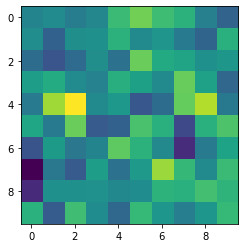

done


In [12]:
"""
Copyright (C) 2019 NVIDIA Corporation.  All rights reserved.
Licensed under the CC BY-NC-SA 4.0 license (https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode).
"""

import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.nn.modules.conv import _ConvNd
from torch.nn.modules.utils import _pair
import numpy as np
import math
# import network.mynn as mynn
# import my_functionals.custom_functional as myF


def conv2d_same(input, kernel, groups,bias=None,stride=1,padding=0,dilation=1):
    n, c, h, w = input.shape
    kout, ki_c_g, kh, kw = kernel.shape
    pw = calc_pad_same(w, w, 1, kw)
    ph = calc_pad_same(h, h, 1, kh)
    pw_l = pw // 2
    pw_r = pw - pw_l
    ph_t = ph // 2
    ph_b = ph - ph_t

    input_ = F.pad(input, (pw_l, pw_r, ph_t, ph_b))
    result = F.conv2d(input_, kernel, bias=bias, stride=stride, padding=padding, dilation=dilation, groups=groups)
    assert result.shape == input.shape
    return result


class GatedSpatialConv2d(_ConvNd):
    def __init__(self, in_channels, out_channels, kernel_size=1, stride=1,
                 padding=0, dilation=1, groups=1, bias=False):
        """

        :param in_channels:
        :param out_channels:
        :param kernel_size:
        :param stride:
        :param padding:
        :param dilation:
        :param groups:
        :param bias:
        """

        kernel_size = _pair(kernel_size)
        stride = _pair(stride)
        padding = _pair(padding)
        dilation = _pair(dilation)
        super(GatedSpatialConv2d, self).__init__(
            in_channels, out_channels, kernel_size, stride, padding, dilation,
            False, _pair(0), groups, bias, 'zeros')

        self._gate_conv = nn.Sequential(
            Norm2d(in_channels+1),
            nn.Conv2d(in_channels+1, in_channels+1, 1),
            nn.ReLU(), 
            nn.Conv2d(in_channels+1, 1, 1),
            Norm2d(1),
            nn.Sigmoid()
        )

    def forward(self, input_features, gating_features):
        """

        :param input_features:  [NxCxHxW]  featuers comming from the shape branch (canny branch).
        :param gating_features: [Nx1xHxW] features comming from the texture branch (resnet). Only one channel feature map.
        :return:
        """
        alphas = self._gate_conv(torch.cat([input_features, gating_features], dim=1))

        input_features = (input_features * (alphas + 1)) 
        return F.conv2d(input_features, self.weight, self.bias, self.stride,
                        self.padding, self.dilation, self.groups)
  
    def reset_parameters(self):
        nn.init.xavier_normal_(self.weight)
        if self.bias is not None:
            nn.init.zeros_(self.bias)


class Conv2dPad(nn.Conv2d):
    def forward(self, input):
        return conv2d_same(input,self.weight,self.groups)

class HighFrequencyGatedSpatialConv2d(_ConvNd):
    def __init__(self, in_channels, out_channels, kernel_size=1, stride=1,
                 padding=0, dilation=1, groups=1, bias=False):
        """

        :param in_channels:
        :param out_channels:
        :param kernel_size:
        :param stride:
        :param padding:
        :param dilation:
        :param groups:
        :param bias:
        """

        kernel_size = _pair(kernel_size)
        stride = _pair(stride)
        padding = _pair(padding)
        dilation = _pair(dilation)
        super(HighFrequencyGatedSpatialConv2d, self).__init__(
            in_channels, out_channels, kernel_size, stride, padding, dilation,
            False, _pair(0), groups, bias)

        self._gate_conv = nn.Sequential(
            Norm2d(in_channels+1),
            nn.Conv2d(in_channels+1, in_channels+1, 1),
            nn.ReLU(), 
            nn.Conv2d(in_channels+1, 1, 1),
            Norm2d(1),
            nn.Sigmoid()
        )

        kernel_size = 7
        sigma = 3

        x_cord = torch.arange(kernel_size).float()
        x_grid = x_cord.repeat(kernel_size).view(kernel_size, kernel_size).float()
        y_grid = x_grid.t().float()
        xy_grid = torch.stack([x_grid, y_grid], dim=-1).float()

        mean = (kernel_size - 1)/2.
        variance = sigma**2.
        gaussian_kernel = (1./(2.*math.pi*variance)) *\
                          torch.exp(
                              -torch.sum((xy_grid - mean)**2., dim=-1) /\
                              (2*variance)
                          )

        gaussian_kernel = gaussian_kernel / torch.sum(gaussian_kernel)

        gaussian_kernel = gaussian_kernel.view(1, 1, kernel_size, kernel_size)
        gaussian_kernel = gaussian_kernel.repeat(in_channels, 1, 1, 1)

        self.gaussian_filter = nn.Conv2d(in_channels=in_channels, out_channels=in_channels, padding=3,
                                         kernel_size=kernel_size, groups=in_channels, bias=False)

        self.gaussian_filter.weight.data = gaussian_kernel
        self.gaussian_filter.weight.requires_grad = False

        self.cw = nn.Conv2d(in_channels * 2, in_channels, 1)
 
        self.procdog = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, 1),
            Norm2d(in_channels),
            nn.Sigmoid()
        )

    def forward(self, input_features, gating_features):
        """

        :param input_features:  [NxCxHxW]  featuers comming from the shape branch (canny branch).
        :param gating_features: [Nx1xHxW] features comming from the texture branch (resnet). Only one channel feature map.
        :return:
        """
        n, c, h, w = input_features.size()
        smooth_features = self.gaussian_filter(input_features)
        dog_features = input_features - smooth_features
        dog_features = self.cw(torch.cat((dog_features, input_features), dim=1))
        
        alphas = self._gate_conv(torch.cat([input_features, gating_features], dim=1))

        dog_features = dog_features * (alphas + 1)

        return F.conv2d(dog_features, self.weight, self.bias, self.stride,
                        self.padding, self.dilation, self.groups)

    def reset_parameters(self):
        nn.init.xavier_normal_(self.weight)
        if self.bias is not None:
            nn.init.zeros_(self.bias)

def t():
    import matplotlib.pyplot as plt

    canny_map_filters_in = 8
    canny_map = np.random.normal(size=(1, canny_map_filters_in, 10, 10))  # NxCxHxW
    resnet_map = np.random.normal(size=(1, 1, 10, 10))  # NxCxHxW
    plt.imshow(canny_map[0, 0])
    plt.show()

    canny_map = torch.from_numpy(canny_map).float()
    resnet_map = torch.from_numpy(resnet_map).float()

    gconv = GatedSpatialConv2d(canny_map_filters_in, canny_map_filters_in,
                               kernel_size=3, stride=1, padding=1)
    output_map = gconv(canny_map, resnet_map)
    print('done')


if __name__ == "__main__":
    t()

In [54]:
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo

__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = Norm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = Norm2d(planes)
        self.downsample = downsample
        self.stride = stride
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = Norm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = Norm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = Norm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=2):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = Norm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                Norm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


def resnet18(pretrained=True, **kwargs):
    """Constructs a ResNet-18 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet18']))
    return model


def resnet34(pretrained=True, **kwargs):
    """Constructs a ResNet-34 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet34']))
    return model


def resnet50(pretrained=True, **kwargs):
    """Constructs a ResNet-50 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet50']))
    return model


def resnet101(pretrained=True, **kwargs):
    """Constructs a ResNet-101 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet101']))
    return model


def resnet152(pretrained=True, **kwargs):
    """Constructs a ResNet-152 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [4, 8, 36, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet152']))
    return model


In [55]:
import sys
from collections import OrderedDict
from functools import partial
import torch.nn as nn
import torch

def bnrelu(channels):
    return nn.Sequential(Norm2d(channels),
                         nn.ReLU(inplace=True))

class GlobalAvgPool2d(nn.Module):

    def __init__(self):
        """Global average pooling over the input's spatial dimensions"""
        super(GlobalAvgPool2d, self).__init__()

    def forward(self, inputs):
        in_size = inputs.size()
        return inputs.view((in_size[0], in_size[1], -1)).mean(dim=2)


class IdentityResidualBlock(nn.Module):

    def __init__(self,
                 in_channels,
                 channels,
                 stride=1,
                 dilation=1,
                 groups=1,
                 norm_act=bnrelu,
                 dropout=None,
                 dist_bn=False
                 ):
        """Configurable identity-mapping residual block

        Parameters
        ----------
        in_channels : int
            Number of input channels.
        channels : list of int
            Number of channels in the internal feature maps.
            Can either have two or three elements: if three construct
            a residual block with two `3 x 3` convolutions,
            otherwise construct a bottleneck block with `1 x 1`, then
            `3 x 3` then `1 x 1` convolutions.
        stride : int
            Stride of the first `3 x 3` convolution
        dilation : int
            Dilation to apply to the `3 x 3` convolutions.
        groups : int
            Number of convolution groups.
            This is used to create ResNeXt-style blocks and is only compatible with
            bottleneck blocks.
        norm_act : callable
            Function to create normalization / activation Module.
        dropout: callable
            Function to create Dropout Module.
        dist_bn: Boolean
            A variable to enable or disable use of distributed BN
        """
        super(IdentityResidualBlock, self).__init__()
        self.dist_bn = dist_bn

        # Check if we are using distributed BN and use the nn from encoding.nn
        # library rather than using standard pytorch.nn


        # Check parameters for inconsistencies
        if len(channels) != 2 and len(channels) != 3:
            raise ValueError("channels must contain either two or three values")
        if len(channels) == 2 and groups != 1:
            raise ValueError("groups > 1 are only valid if len(channels) == 3")

        is_bottleneck = len(channels) == 3
        need_proj_conv = stride != 1 or in_channels != channels[-1]

        self.bn1 = norm_act(in_channels)
        if not is_bottleneck:
            layers = [
                ("conv1", nn.Conv2d(in_channels,
                                    channels[0],
                                    3,
                                    stride=stride,
                                    padding=dilation,
                                    bias=False,
                                    dilation=dilation)),
                ("bn2", norm_act(channels[0])),
                ("conv2", nn.Conv2d(channels[0], channels[1],
                                    3,
                                    stride=1,
                                    padding=dilation,
                                    bias=False,
                                    dilation=dilation))
            ]
            if dropout is not None:
                layers = layers[0:2] + [("dropout", dropout())] + layers[2:]
        else:
            layers = [
                ("conv1",
                 nn.Conv2d(in_channels,
                           channels[0],
                           1,
                           stride=stride,
                           padding=0,
                           bias=False)),
                ("bn2", norm_act(channels[0])),
                ("conv2", nn.Conv2d(channels[0],
                                    channels[1],
                                    3, stride=1,
                                    padding=dilation, bias=False,
                                    groups=groups,
                                    dilation=dilation)),
                ("bn3", norm_act(channels[1])),
                ("conv3", nn.Conv2d(channels[1], channels[2],
                                    1, stride=1, padding=0, bias=False))
            ]
            if dropout is not None:
                layers = layers[0:4] + [("dropout", dropout())] + layers[4:]
        self.convs = nn.Sequential(OrderedDict(layers))

        if need_proj_conv:
            self.proj_conv = nn.Conv2d(
                in_channels, channels[-1], 1, stride=stride, padding=0, bias=False)

    def forward(self, x):
        """
        This is the standard forward function for non-distributed batch norm
        """
        if hasattr(self, "proj_conv"):
            bn1 = self.bn1(x)
            shortcut = self.proj_conv(bn1)
        else:
            shortcut = x.clone()
            bn1 = self.bn1(x)

        out = self.convs(bn1)
        out.add_(shortcut)
        return out




class WiderResNet(nn.Module):

    def __init__(self,
                 structure,
                 norm_act=bnrelu,
                 classes=0
                 ):
        """Wider ResNet with pre-activation (identity mapping) blocks

        Parameters
        ----------
        structure : list of int
            Number of residual blocks in each of the six modules of the network.
        norm_act : callable
            Function to create normalization / activation Module.
        classes : int
            If not `0` also include global average pooling and \
            a fully-connected layer with `classes` outputs at the end
            of the network.
        """
        super(WiderResNet, self).__init__()
        self.structure = structure

        if len(structure) != 6:
            raise ValueError("Expected a structure with six values")

        # Initial layers
        self.mod1 = nn.Sequential(OrderedDict([
            ("conv1", nn.Conv2d(4, 64, 3, stride=1, padding=1, bias=False))
        ]))

        # Groups of residual blocks
        in_channels = 64
        channels = [(128, 128), (256, 256), (512, 512), (512, 1024),
                    (512, 1024, 2048), (1024, 2048, 4096)]
        for mod_id, num in enumerate(structure):
            # Create blocks for module
            blocks = []
            for block_id in range(num):
                blocks.append((
                    "block%d" % (block_id + 1),
                    IdentityResidualBlock(in_channels, channels[mod_id],
                                          norm_act=norm_act)
                ))

                # Update channels and p_keep
                in_channels = channels[mod_id][-1]

            # Create module
            if mod_id <= 4:
                self.add_module("pool%d" %
                                (mod_id + 2), nn.MaxPool2d(3, stride=2, padding=1))
            self.add_module("mod%d" % (mod_id + 2), nn.Sequential(OrderedDict(blocks)))

        # Pooling and predictor
        self.bn_out = norm_act(in_channels)
        if classes != 0:
            self.classifier = nn.Sequential(OrderedDict([
                ("avg_pool", GlobalAvgPool2d()),
                ("fc", nn.Linear(in_channels, classes))
            ]))

    def forward(self, img):
        out = self.mod1(img)
        out = self.mod2(self.pool2(out))
        out = self.mod3(self.pool3(out))
        out = self.mod4(self.pool4(out))
        out = self.mod5(self.pool5(out))
        out = self.mod6(self.pool6(out))
        out = self.mod7(out)
        out = self.bn_out(out)

        if hasattr(self, "classifier"):
            out = self.classifier(out)

        return out


class WiderResNetA2(nn.Module):

    def __init__(self,
                 structure,
                 norm_act=bnrelu,
                 classes=0,
                 dilation=False,
                 dist_bn=False
                 ):
        """Wider ResNet with pre-activation (identity mapping) blocks

        This variant uses down-sampling by max-pooling in the first two blocks and \
         by strided convolution in the others.

        Parameters
        ----------
        structure : list of int
            Number of residual blocks in each of the six modules of the network.
        norm_act : callable
            Function to create normalization / activation Module.
        classes : int
            If not `0` also include global average pooling and a fully-connected layer
            \with `classes` outputs at the end
            of the network.
        dilation : bool
            If `True` apply dilation to the last three modules and change the
            \down-sampling factor from 32 to 8.
        """
        super(WiderResNetA2, self).__init__()
        self.dist_bn = dist_bn

        # If using distributed batch norm, use the encoding.nn as oppose to torch.nn


        nn.Dropout = nn.Dropout2d
        norm_act = bnrelu
        self.structure = structure
        self.dilation = dilation

        if len(structure) != 6:
            raise ValueError("Expected a structure with six values")

        # Initial layers
        self.mod1 = torch.nn.Sequential(OrderedDict([
            ("conv1", nn.Conv2d(4, 64, 3, stride=1, padding=1, bias=False))
        ]))

        # Groups of residual blocks
        in_channels = 64
        channels = [(128, 128), (256, 256), (512, 512), (512, 1024), (512, 1024, 2048),
                    (1024, 2048, 4096)]
        for mod_id, num in enumerate(structure):
            # Create blocks for module
            blocks = []
            for block_id in range(num):
                if not dilation:
                    dil = 1
                    stride = 2 if block_id == 0 and 2 <= mod_id <= 4 else 1
                else:
                    if mod_id == 3:
                        dil = 2
                    elif mod_id > 3:
                        dil = 4
                    else:
                        dil = 1
                    stride = 2 if block_id == 0 and mod_id == 2 else 1

                if mod_id == 4:
                    drop = partial(nn.Dropout, p=0.3)
                elif mod_id == 5:
                    drop = partial(nn.Dropout, p=0.5)
                else:
                    drop = None

                blocks.append((
                    "block%d" % (block_id + 1),
                    IdentityResidualBlock(in_channels,
                                          channels[mod_id], norm_act=norm_act,
                                          stride=stride, dilation=dil,
                                          dropout=drop, dist_bn=self.dist_bn)
                ))

                # Update channels and p_keep
                in_channels = channels[mod_id][-1]

            # Create module
            if mod_id < 2:
                self.add_module("pool%d" %
                                (mod_id + 2), nn.MaxPool2d(3, stride=2, padding=1))
            self.add_module("mod%d" % (mod_id + 2), nn.Sequential(OrderedDict(blocks)))

        # Pooling and predictor
        self.bn_out = norm_act(in_channels)
        if classes != 0:
            self.classifier = nn.Sequential(OrderedDict([
                ("avg_pool", GlobalAvgPool2d()),
                ("fc", nn.Linear(in_channels, classes))
            ]))

    def forward(self, img):
        out = self.mod1(img)
        out = self.mod2(self.pool2(out))
        out = self.mod3(self.pool3(out))
        out = self.mod4(out)
        out = self.mod5(out)
        out = self.mod6(out)
        out = self.mod7(out)
        out = self.bn_out(out)

        if hasattr(self, "classifier"):
            return self.classifier(out)
        else:
            return out


_NETS = {
    "16": {"structure": [1, 1, 1, 1, 1, 1]},
    "20": {"structure": [1, 1, 1, 3, 1, 1]},
    "38": {"structure": [3, 3, 6, 3, 1, 1]},
}

__all__ = []
for name, params in _NETS.items():
    net_name = "wider_resnet" + name
    setattr(sys.modules[__name__], net_name, partial(WiderResNet, **params))
    __all__.append(net_name)
for name, params in _NETS.items():
    net_name = "wider_resnet" + name + "_a2"
    setattr(sys.modules[__name__], net_name, partial(WiderResNetA2, **params))
    __all__.append(net_name)


In [56]:
"""
Copyright (C) 2019 NVIDIA Corporation.  All rights reserved.
Licensed under the CC BY-NC-SA 4.0 license (https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode).

# Code Adapted from:
# https://github.com/sthalles/deeplab_v3
#
# MIT License
#
# Copyright (c) 2018 Thalles Santos Silva
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
"""

import torch
import torch.nn.functional as F
from torch import nn

from torch.autograd import Variable

# from my_functionals import GatedSpatialConv as gsc

class Crop(nn.Module):
    def __init__(self, axis, offset):
        super(Crop, self).__init__()
        self.axis = axis
        self.offset = offset

    def forward(self, x, ref):
        """
        :param x: input layer
        :param ref: reference usually data in
        :return:
        """
        for axis in range(self.axis, x.dim()):
            ref_size = ref.size(axis)
            indices = torch.arange(self.offset, self.offset + ref_size).long()
            indices = x.data.new().resize_(indices.size()).copy_(indices).long()
            x = x.index_select(axis, Variable(indices))
        return x


class MyIdentity(nn.Module):
    def __init__(self, axis, offset):
        super(MyIdentity, self).__init__()
        self.axis = axis
        self.offset = offset

    def forward(self, x, ref):
        """
        :param x: input layer
        :param ref: reference usually data in
        :return:
        """
        return x

class SideOutputCrop(nn.Module):
    """
    This is the original implementation ConvTranspose2d (fixed) and crops
    """

    def __init__(self, num_output, kernel_sz=None, stride=None, upconv_pad=0, do_crops=True):
        super(SideOutputCrop, self).__init__()
        self._do_crops = do_crops
        self.conv = nn.Conv2d(num_output, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True)

        if kernel_sz is not None:
            self.upsample = True
            self.upsampled = nn.ConvTranspose2d(1, out_channels=1, kernel_size=kernel_sz, stride=stride,
                                                padding=upconv_pad,
                                                bias=False)
            ##doing crops
            if self._do_crops:
                self.crops = Crop(2, offset=kernel_sz // 4)
            else:
                self.crops = MyIdentity(None, None)
        else:
            self.upsample = False

    def forward(self, res, reference=None):
        side_output = self.conv(res)
        if self.upsample:
            side_output = self.upsampled(side_output)
            side_output = self.crops(side_output, reference)

        return side_output


class _AtrousSpatialPyramidPoolingModule(nn.Module):
    '''
    operations performed:
      1x1 x depth
      3x3 x depth dilation 6
      3x3 x depth dilation 12
      3x3 x depth dilation 18
      image pooling
      concatenate all together
      Final 1x1 conv
    '''

    def __init__(self, in_dim, reduction_dim=256, output_stride=16, rates=[6, 12, 18]):
        super(_AtrousSpatialPyramidPoolingModule, self).__init__()

        # Check if we are using distributed BN and use the nn from encoding.nn
        # library rather than using standard pytorch.nn

        if output_stride == 8:
            rates = [2 * r for r in rates]
        elif output_stride == 16:
            pass
        else:
            raise 'output stride of {} not supported'.format(output_stride)

        self.features = []
        # 1x1
        self.features.append(
            nn.Sequential(nn.Conv2d(in_dim, reduction_dim, kernel_size=1, bias=False),
                          Norm2d(reduction_dim), nn.ReLU(inplace=True)))
        # other rates
        for r in rates:
            self.features.append(nn.Sequential(
                nn.Conv2d(in_dim, reduction_dim, kernel_size=3,
                          dilation=r, padding=r, bias=False),
                Norm2d(reduction_dim),
                nn.ReLU(inplace=True)
            ))
        self.features = torch.nn.ModuleList(self.features)

        # img level features
        self.img_pooling = nn.AdaptiveAvgPool2d(1)
        self.img_conv = nn.Sequential(
            nn.Conv2d(in_dim, reduction_dim, kernel_size=1, bias=False),
            Norm2d(reduction_dim), nn.ReLU(inplace=True))
        self.edge_conv = nn.Sequential(
            nn.Conv2d(1, reduction_dim, kernel_size=1, bias=False),
            Norm2d(reduction_dim), nn.ReLU(inplace=True))
         

    def forward(self, x, edge):
        x_size = x.size()

        img_features = self.img_pooling(x)
        img_features = self.img_conv(img_features)
        img_features = F.interpolate(img_features, x_size[2:],
                                     mode='bilinear',align_corners=True)
        out = img_features

        edge_features = F.interpolate(edge, x_size[2:],
                                      mode='bilinear',align_corners=True)
        edge_features = self.edge_conv(edge_features)
        out = torch.cat((out, edge_features), 1)

        for f in self.features:
            y = f(x)
            out = torch.cat((out, y), 1)
        return out

class GSCNN(nn.Module):
    '''
    Wide_resnet version of DeepLabV3
    mod1
    pool2
    mod2 str2
    pool3
    mod3-7

      structure: [3, 3, 6, 3, 1, 1]
      channels = [(128, 128), (256, 256), (512, 512), (512, 1024), (512, 1024, 2048),
                  (1024, 2048, 4096)]
    '''

    def __init__(self, num_classes = 2, trunk=None, criterion=None):
        
        super(GSCNN, self).__init__()
        self.criterion = criterion
        self.num_classes = num_classes

        wide_resnet = wider_resnet38_a2(classes=2, dilation=True)
        wide_resnet = torch.nn.DataParallel(wide_resnet)
        
        wide_resnet = wide_resnet.module
        self.mod1 = wide_resnet.mod1
        self.mod2 = wide_resnet.mod2
        self.mod3 = wide_resnet.mod3
        self.mod4 = wide_resnet.mod4
        self.mod5 = wide_resnet.mod5
        self.mod6 = wide_resnet.mod6
        self.mod7 = wide_resnet.mod7
        self.pool2 = wide_resnet.pool2
        self.pool3 = wide_resnet.pool3
        self.interpolate = F.interpolate
        del wide_resnet

        self.dsn1 = nn.Conv2d(64, 1, 1)
        self.dsn3 = nn.Conv2d(256, 1, 1)
        self.dsn4 = nn.Conv2d(512, 1, 1)
        self.dsn7 = nn.Conv2d(4096, 1, 1)

        self.res1 = BasicBlock(64, 64, stride=1, downsample=None)
        self.d1 = nn.Conv2d(64, 32, 1)
        self.res2 = BasicBlock(32, 32, stride=1, downsample=None)
        self.d2 = nn.Conv2d(32, 16, 1)
        self.res3 = BasicBlock(16, 16, stride=1, downsample=None)
        self.d3 = nn.Conv2d(16, 8, 1)
        self.fuse = nn.Conv2d(8, 1, kernel_size=1, padding=0, bias=False)

        self.cw = nn.Conv2d(2, 1, kernel_size=1, padding=0, bias=False)

        self.gate1 = GatedSpatialConv2d(32, 32)
        self.gate2 = GatedSpatialConv2d(16, 16)
        self.gate3 = GatedSpatialConv2d(8, 8)
         
        self.aspp = _AtrousSpatialPyramidPoolingModule(4096, 256,
                                                       output_stride=8)

        self.bot_fine = nn.Conv2d(128, 48, kernel_size=1, bias=False)
        self.bot_aspp = nn.Conv2d(1280 + 256, 256, kernel_size=1, bias=False)

        self.final_seg = nn.Sequential(
            nn.Conv2d(256 + 48, 256, kernel_size=3, padding=1, bias=False),
            Norm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            Norm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, num_classes, kernel_size=1, bias=False))

        self.sigmoid = nn.Sigmoid()
        initialize_weights(self.final_seg)

    def forward(self, inp, gts=None):

        x_size = inp.size() 

        # res 1
        m1 = self.mod1(inp)
        print("m1 passed.")
        # res 2
        m2 = self.mod2(self.pool2(m1))
        print("m2 passed.")
        # res 3
        m3 = self.mod3(self.pool3(m2))
        print("m3 passed.")
        # res 4-7
        m4 = self.mod4(m3)
        print("m4 passed.")
        m5 = self.mod5(m4)
        print("m5 passed.")
        m6 = self.mod6(m5)
        print("m6 passed.")
        m7 = self.mod7(m6) 
        print("m7 passed.")

        s3 = F.interpolate(self.dsn3(m3), x_size[2:],
                            mode='bilinear', align_corners=True)
        s4 = F.interpolate(self.dsn4(m4), x_size[2:],
                            mode='bilinear', align_corners=True)
        s7 = F.interpolate(self.dsn7(m7), x_size[2:],
                            mode='bilinear', align_corners=True)
        
        m1f = F.interpolate(m1, x_size[2:], mode='bilinear', align_corners=True)

        im_arr = inp.cpu().numpy().transpose((0,2,3,1)).astype(np.uint8)
        canny = np.zeros((x_size[0], 1, x_size[2], x_size[3]))
        for i in range(x_size[0]):
            canny[i] = cv2.Canny(im_arr[i],10,100)
        canny = torch.from_numpy(canny).float()

        cs = self.res1(m1f)
        cs = F.interpolate(cs, x_size[2:],
                           mode='bilinear', align_corners=True)
        cs = self.d1(cs)
        cs = self.gate1(cs, s3)
        cs = self.res2(cs)
        cs = F.interpolate(cs, x_size[2:],
                           mode='bilinear', align_corners=True)
        cs = self.d2(cs)
        cs = self.gate2(cs, s4)
        cs = self.res3(cs)
        cs = F.interpolate(cs, x_size[2:],
                           mode='bilinear', align_corners=True)
        cs = self.d3(cs)
        cs = self.gate3(cs, s7)
        cs = self.fuse(cs)
        cs = F.interpolate(cs, x_size[2:],
                           mode='bilinear', align_corners=True)
        edge_out = self.sigmoid(cs)
        cat = torch.cat((edge_out, canny), dim=1)
        acts = self.cw(cat)
        acts = self.sigmoid(acts)

        # aspp
        x = self.aspp(m7, acts)
        dec0_up = self.bot_aspp(x)

        dec0_fine = self.bot_fine(m2)
        dec0_up = self.interpolate(dec0_up, m2.size()[2:], mode='bilinear',align_corners=True)
        dec0 = [dec0_fine, dec0_up]
        dec0 = torch.cat(dec0, 1)

        dec1 = self.final_seg(dec0)  
        seg_out = self.interpolate(dec1, x_size[2:], mode='bilinear')            
       
#         if self.training:
#             return self.criterion((seg_out, edge_out), gts)              
#         else:
        return seg_out, edge_out

In [57]:
net = GSCNN()
loss_dict = None
loss_dict, edge_out = net(test)

/Users/shimash/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  


m1 passed.
m2 passed.
m3 passed.
m4 passed.
m5 passed.
m6 passed.
m7 passed.


In [58]:
print(loss_dict.shape)

torch.Size([2, 2, 224, 224])


In [22]:
print(edge_out.shape)

torch.Size([2, 1, 224, 224])


In [52]:
# print(eval_mask_boundary(loss_dict.detach().numpy(), mask.detach().numpy()))

In [53]:
np.sum(seg2bmap(mask.detach().numpy()))

17185